# Post-hoc statistics about generated results

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import random
import seaborn as sns
from collections import Counter


from paths import bsc_path, word_plot_res_path, word_plot_info_path, word_cluster_dbscan_plot_path, word_cluster_kmeans_plot_path
from reshandler import EncoderResHandler, ClusterHandler
from measurements import *
from my_utils import remove_starting_space, remove_newline

## 1. Direction Consistency

In [4]:
vars = []
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    if not datapath.endswith(".npy"): 
        continue
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()
    res = reshandler.data

    angles, var = DirectionalConsistency.analyze(res)
    vars.append(var)

In [5]:
np.mean(vars)

0.34797691926436014

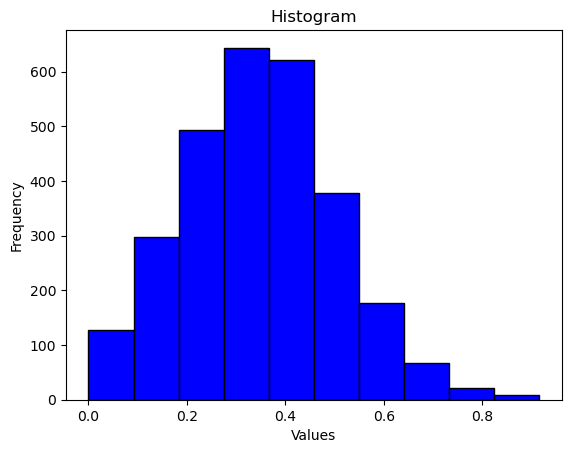

In [6]:
# Create a histogram
plt.hist(vars, bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


## 2. Clustering

### DBSCAN
- Note that this part is non-fix number clustering, meaning that the total number of clusters is not fixed for the dataset. However, we could see that, when we find a configuration that produces in general comparable number of clusters as the number of segments in reality, the degree of matching is quite high, i.e. for most words the clustering algorithm has found out the correct number of clusters (therefore diff = 0), or if mistaken, the algorithm has one more cluster, which is basically matching the ground truth that we have.  

#### Looping over the data

In [18]:
num_segments_list = []
num_clusters_list = []

file_prefixes = []
infos = []
labelss = []
ress = []

In [19]:
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    if not datapath.endswith(".npy"): 
        continue
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()

    res = reshandler.data
    info = reshandler.info

    labels, num_clusters = Clusterer.dbscan(res, r=0.35, m=1)

    num_segments_list.append(len(remove_starting_space(info[1]).split(" ")))
    num_clusters_list.append(num_clusters)

    file_prefixes.append(reshandler.file_prefix)
    infos.append(info)
    ress.append(res)
    labelss.append(labels)

In [20]:
np.mean(num_segments_list), np.mean(num_clusters_list)

(2.972535211267606, 2.948943661971831)

In [21]:
# Create a DataFrame
df = pd.DataFrame({'Segments': num_segments_list, 'Clusters': num_clusters_list})

# Add a new column for the difference
df['Difference'] = df['Segments'] - df['Clusters']

df

,Segments,Clusters,Difference
0,3,3,0
1,2,2,0
2,3,6,-3
3,5,5,0
4,6,3,3
...,...,...,...
2835,3,2,1
2836,1,2,-1
2837,8,5,3
2838,4,3,1


In [22]:
data_array = df['Difference'].to_numpy()
# Calculate mean
mean = np.mean(data_array)
# Calculate standard deviation
std_dev = np.std(data_array)
print(mean, std_dev)

0.023591549295774648 1.7554161023309978


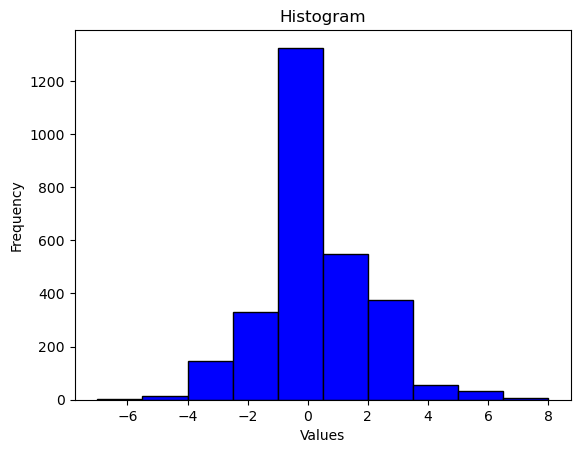

In [23]:
# Create a histogram
plt.hist(df['Difference'].tolist(), bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

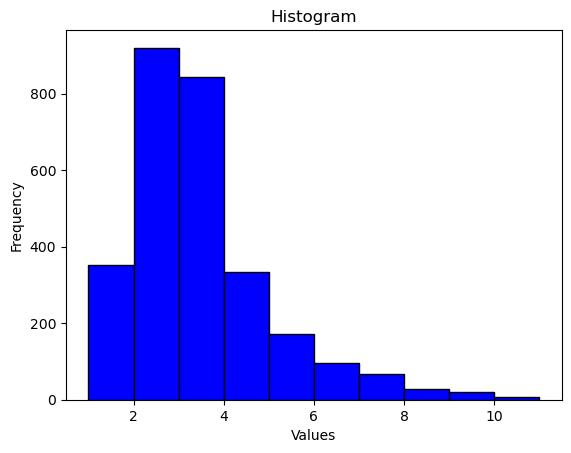

In [24]:
# Create a histogram
plt.hist(df['Segments'].tolist(), bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

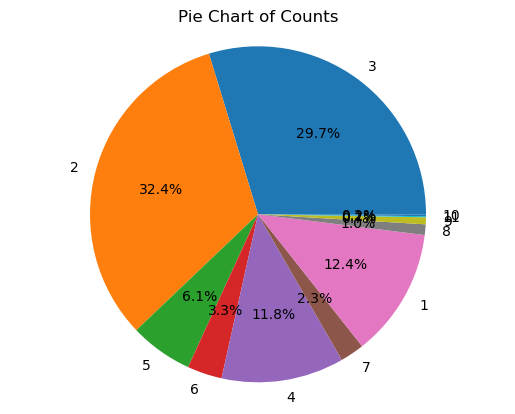

In [25]:
# Use Counter to count the occurrences of each value
value_counts = Counter(df['Segments'].tolist())

# Extract the values and their counts
values = list(value_counts.keys())
counts = list(value_counts.values())

# Create a pie chart
plt.pie(counts, labels=values, autopct='%1.1f%%')
plt.title('Pie Chart of Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

#### Save results

In [26]:
clhandler = ClusterHandler(put_path=os.path.join(bsc_path, "dbscan.intgrt"), 
                           data=(file_prefixes, infos, ress, labelss))
# file prefix, info, ress, preds
clhandler.save()

#### Plot the Clusters

In [27]:
randidx = random.randint(0, len(file_prefixes))
file_name = file_prefixes[randidx]
info_token, info_produce_segs = infos[randidx]
res = ress[randidx]
labels = labelss[randidx]
print(file_name, info_token, info_produce_segs)

PT_0926172946_194_full_s3601b_00000461_other other  ah dh er


In [28]:
df = pd.DataFrame(res)
df["tag"] = labels

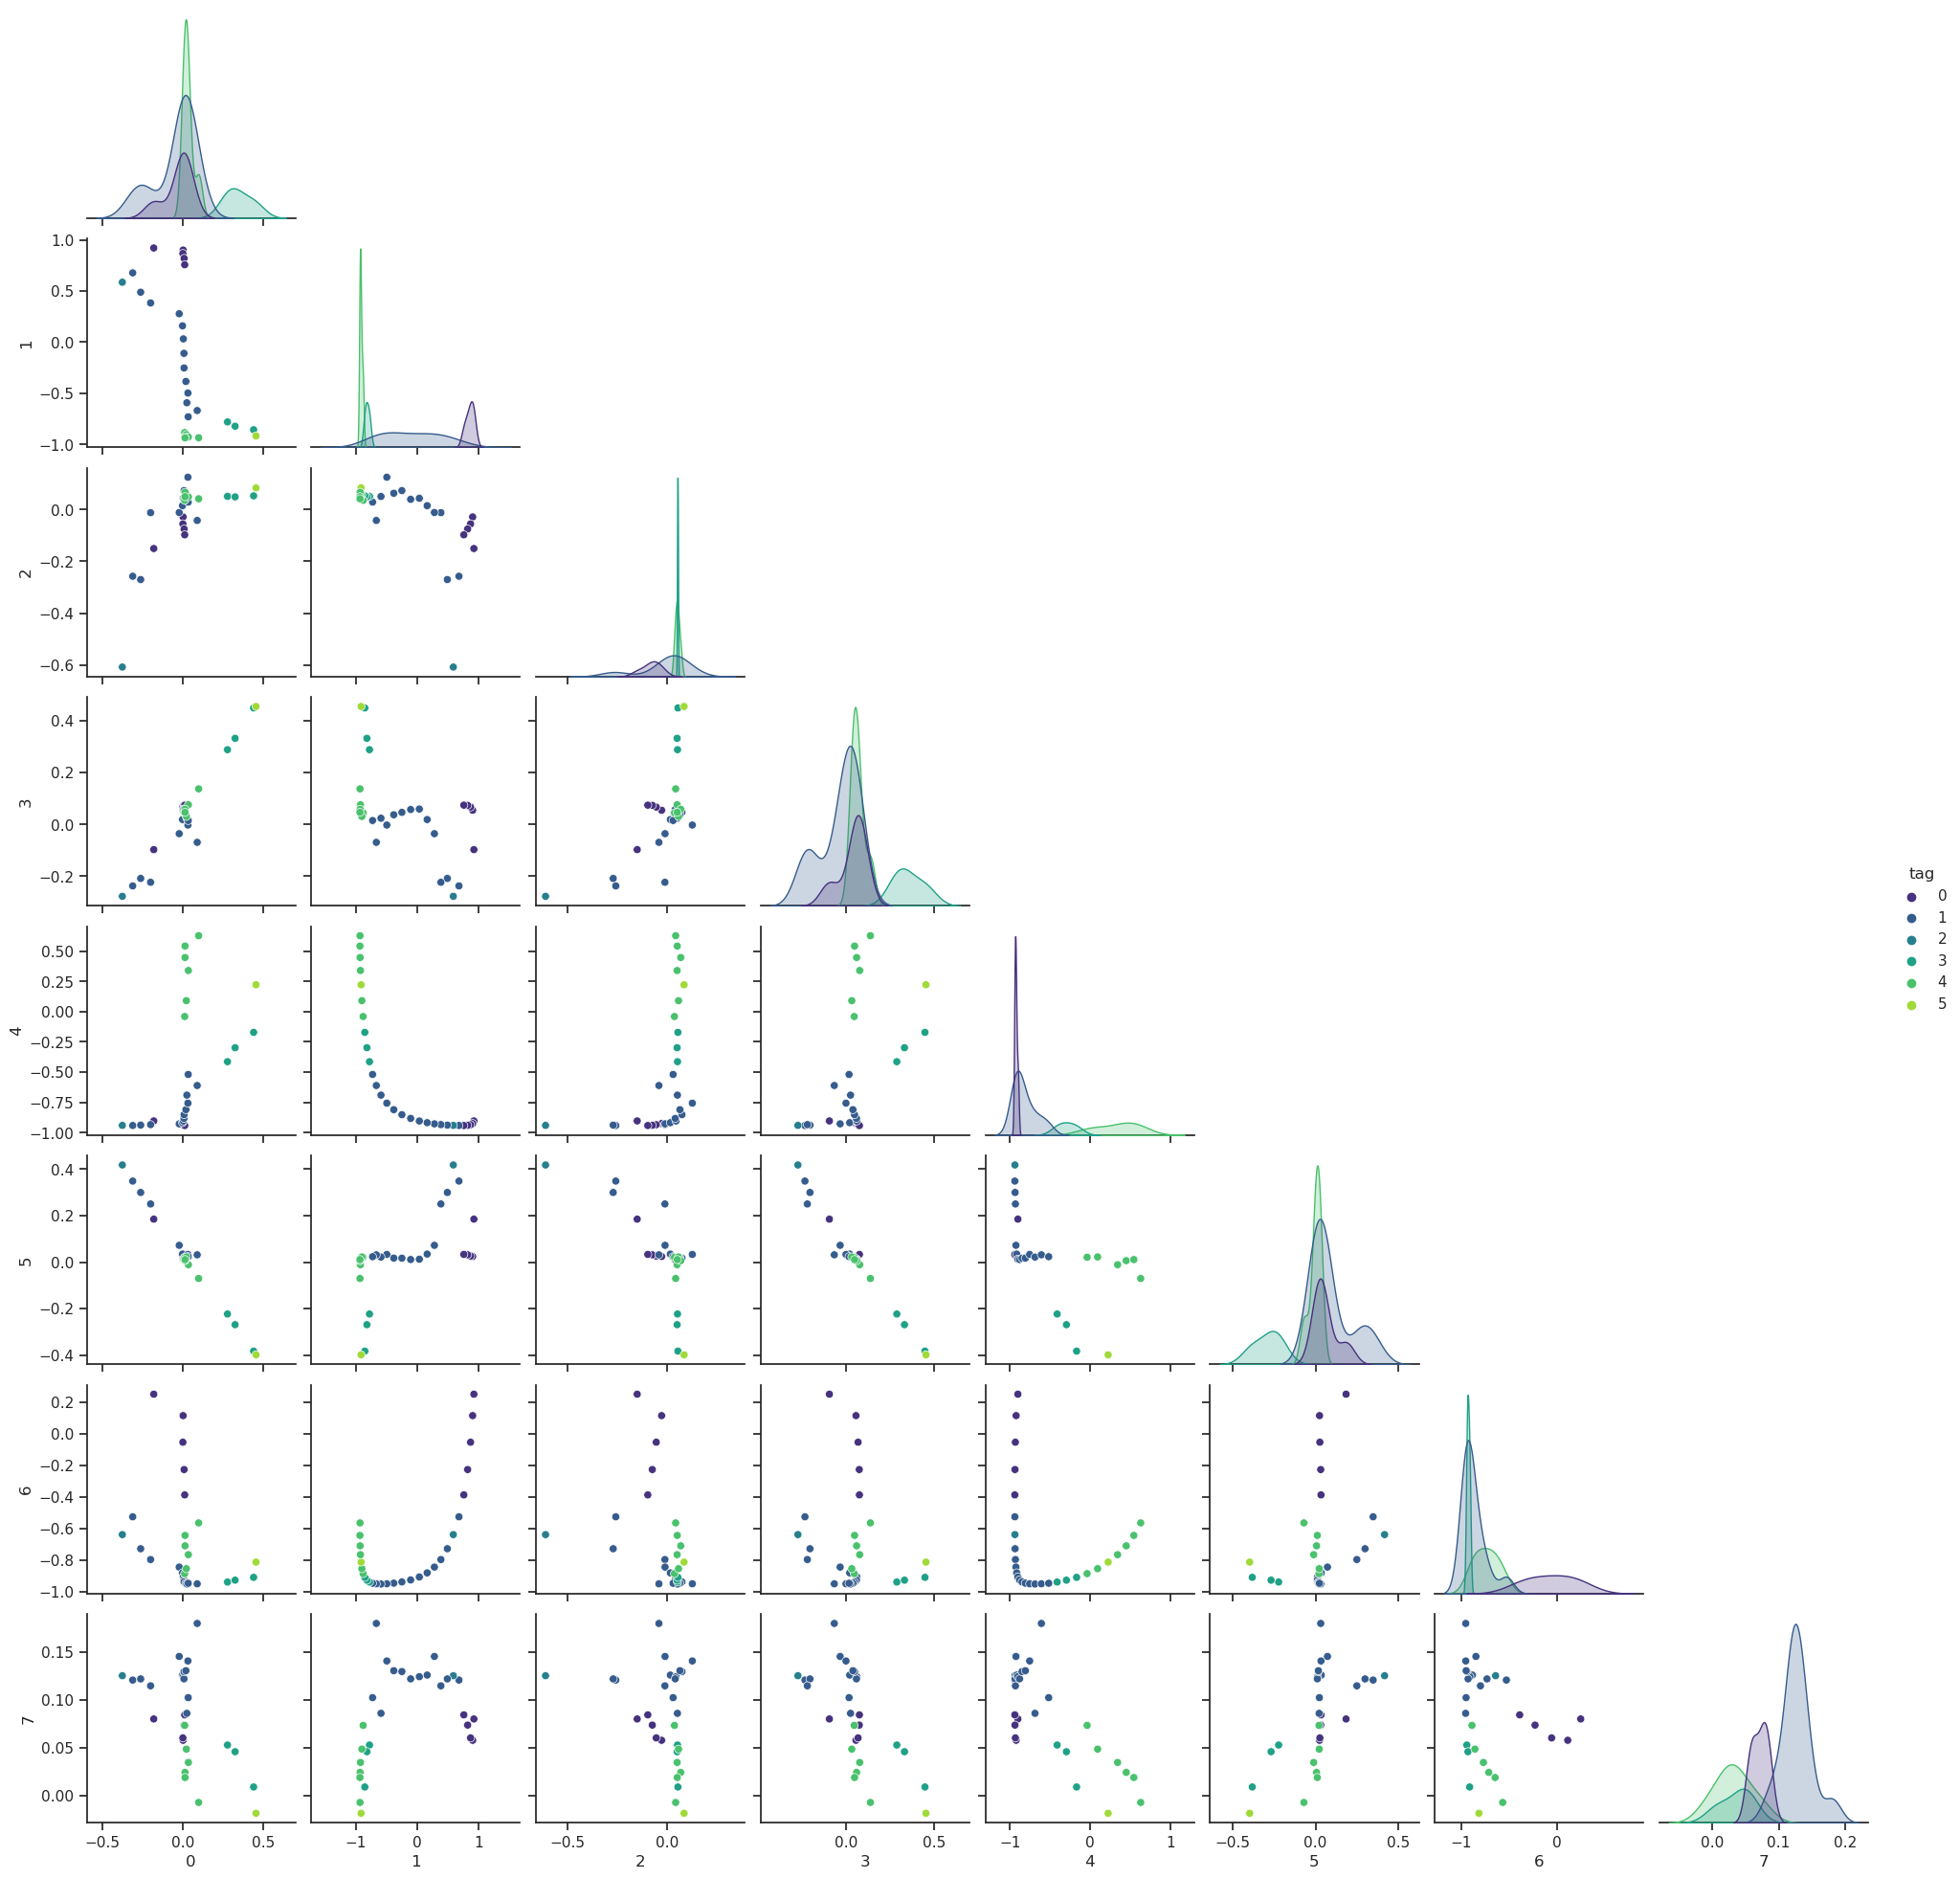

In [29]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,hue='tag', corner=True, palette=sns.color_palette("viridis", max(labels) + 1))

### Kmeans++
使用kmeans我们需要为每一次clustering传入一个number of clusters的参数，因此我们也得以控制每一个clustering结果中聚类的数量，这样我们就可以把每一个聚类和这个词中的real segment对应起来。

#### Looping over the data

In [2]:
file_prefixes = []
infos = []
labelss = []
ress = []
centerss = []

In [4]:
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()

    res = reshandler.data
    info = reshandler.info

    # Number of clusters (you can adjust this)
    num_clusters = len(remove_newline(remove_starting_space(info[1])).split(" "))

    labels, centers = Clusterer.kmeans(data=res, 
                                       n_clusters=num_clusters)

    file_prefixes.append(reshandler.file_prefix)
    infos.append(info)
    ress.append(res)
    labelss.append(labels)
    centerss.append(centers)

In [5]:
def oneOut2ProgFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2", "cluster"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["timestep"] = df.index
    df = df[["timestep"] + cols]
    return df
def oneOut2CenterFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["cluster"] = df.index
    df = df[["cluster"] + cols]
    return df
def minmax(arr, a=-1, b=1): 
    min = arr.min()
    max = arr.max()
    return (b - a) * ((arr - min) / (max - min)) + a
def operate_on(arr): 
    # return minmax(arr)
    return arr
def framify(these_hids): 
    # these are token categories to be included
    # these hids are the corresponding hids
    # these numtags are the corresponding tags, named using indices in these
    # these_hids = st.zscore(these_hids, axis=0)
    df = pd.DataFrame(data=these_hids)
    # df = df.rename(columns={0: "dim_0", 1: "dim_1", 2: "dim_2"})
    df['dim_0_norm'] = operate_on(df['dim_0'])
    df['dim_1_norm'] = operate_on(df['dim_1'])
    df['dim_2_norm'] = operate_on(df['dim_2'])
    return df

def plot3dtrajectory_plusCenter(X, C): 
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }

    fig = px.line_3d(X, x="dim_0_norm", y="dim_1_norm", z="dim_2_norm", 
                     hover_data=["timestep"], color="cluster", markers=True)

    fig.update_traces(marker=dict(size=2, color="red"))

    fig.add_scatter3d(x=C["dim_0_norm"], y=C["dim_1_norm"], z=C["dim_2_norm"], mode='markers', marker=dict(size=5), name="Centers")

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

def save_html(htmlplot, plot_path, file_name, info_token, info_produce_segs): 
    save_html_path = os.path.join(plot_path, "{}.html".format(file_name))
    with open(save_html_path, "w") as f: 
        f.write('<meta charset="UTF-8">')
        f.write("<h3>Token: {}</h3>".format(info_token))
        f.write("<h3>Produced Segments: {}</h3>".format(info_produce_segs))
        f.write("<hr>")
        f.write(htmlplot)

In [6]:
for idx in range(len(file_prefixes)): 
    file_name = file_prefixes[idx]
    info_token, info_produce_segs = infos[idx]
    res = ress[idx]
    labels = labelss[idx]
    centers = centerss[idx]

    # Convert the list to a NumPy array with shape (frame_num, 1)
    labels_array = np.array(labels).reshape(-1, 1)

    # Combine the arrays horizontally (horizontally stack them)
    combined_array = np.hstack((res, labels_array))

    res_df = oneOut2ProgFrame(combined_array) # one in batch
    res_df = framify(res_df)

    center_df = oneOut2CenterFrame(centers)
    center_df = framify(center_df)

    htmlplot = plot3dtrajectory_plusCenter(res_df, center_df)
    
    save_html(htmlplot=htmlplot, 
              plot_path=word_cluster_kmeans_plot_path, 
              file_name=file_name, 
              info_token=info_token, info_produce_segs=info_produce_segs)

In [7]:
clhandler = ClusterHandler(put_path=os.path.join(bsc_path, "kmeans.intgrt"), 
                           data=(file_prefixes, infos, ress, (labelss, centerss)))
# file prefix, info, ress, preds
clhandler.save()

#### Post-hoc Analyses

In [8]:
clhandler = ClusterHandler(put_path=os.path.join(bsc_path, "kmeans.intgrt"))
# file prefix, info, ress, preds
clhandler.read()
(file_prefixes, infos, ress, (labelss, centerss)) = clhandler.data

In [9]:
def check_and_order(data): 
    if len(data) == 1: 
        # only when 3 we can have returning point
        return data, False
    
    return_switch = False
    done_buffer = []
    last_item = data[0]
    for i in data: 
        if last_item != i: 
            # there is a change
            if last_item in done_buffer: 
                # meaning that this has appeared before
                return_switch = True
            else: 
                done_buffer.append(last_item)
        last_item = i

    if last_item in done_buffer: 
        return_switch = True
    else: 
        done_buffer.append(last_item)
    return done_buffer, return_switch

In [10]:
"""NOTE: not correct yet. """


# def get_detailed_check(data, order): 
#     at = 0
#     out = []

#     for i in data: 
#         print(at)
#         if at >= len(order): 
#             out.append(1)   # returning
#         else: 
#             if order[at] == i: 
#                 # first-time, non-alternating point
#                 out.append(0)
#             else: 
#                 at += 1
#                 if at >= len(order): 
#                     out.append(1)   # returning
#                 elif order[at] == i: 
#                     # first-time, alternating point
#                     out.append(0)
#                 else: 
#                     # not first-time
#                     out.append(1)
#     return out

# x = [0, 0, 0, 1, 2, 1, 0, 3, 3]
# order, whether = check_and_order(x)
# print(order, whether)
# get_detailed_check(x, order)

'NOTE: not correct yet. '

In [11]:
return_count = 0
total_count = 0

for labels in labelss: 
    _, returning = check_and_order(labels)
    if returning: 
        return_count += 1
    total_count += 1

In [12]:
return_count/total_count
# i.e. around 30% of the tried validation set portion is "returning"
# we might think it is quite successful. But then it comes the question of how 
# we can deal with this. 
# Probably we could simply exclude them as a start. By doing so at least we could be able to
# check how clustered the phonemes are in the hidden representation. 

0.22359154929577466

In [13]:
hidr = np.empty((0, 3))
tags = []
returnings = []  # 0 is not returning, 1 is returning

for idx in range(len(ress)):
    info_token, info_produce_segs = infos[idx]
    res = ress[idx]
    labels = labelss[idx]

    order, returning = check_and_order(labels)
    order_mapping = {order: index for index, order in enumerate(order)}
    hidr = np.concatenate((hidr, res), axis=0)

    segs = remove_newline(remove_starting_space(info_produce_segs)).split(" ")
    tags += [segs[order_mapping[l]] for l in labels]
    returnings += [returning for l in labels]

In [14]:
returnings.count(True) / len(returnings)
# Comparing this to return_count/total_count, 
# we can find that the proportion is larger. One could be that returning words are in general longer
# and another is that we counted all segments in returning words as returning
# but it might only be a part of them that is returning
# haven't solved this yet, it should take some thinking time. But not affecting demo this time. 

0.314099069632214

In [15]:
def minmax(arr, a=-1, b=1): 
    min = arr.min()
    max = arr.max()
    return (b - a) * ((arr - min) / (max - min)) + a
def operate_on(arr): 
    # return minmax(arr)
    return arr
def framify_group(these_hids, these_tags): 
    # these are token categories to be included
    # these hids are the corresponding hids
    # these numtags are the corresponding tags, named using indices in these
    # these_hids = st.zscore(these_hids, axis=0)
    df = pd.DataFrame(data=these_hids)
    df = df.rename(columns={0: "dim_0", 1: "dim_1", 2: "dim_2"})
    df['dim_0_norm'] = operate_on(df['dim_0'])
    df['dim_1_norm'] = operate_on(df['dim_1'])
    df['dim_2_norm'] = operate_on(df['dim_2'])

    df["Tag"] = these_tags
    return df
def plot3dGroup(X, y): 
    df = framify_group(X, y)
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    fig = px.scatter_3d(df, x="dim_0_norm", y="dim_1_norm", z="dim_2_norm",
                color='Tag')
    fig.update_traces(marker=dict(size=2),
                    selector=dict(mode='markers'))
    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.update_layout(legend_title_text='Class')
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

In [16]:
def save_html(htmlplot, save_name): 
    save_html_path = os.path.join(bsc_path, "{}.html".format(save_name))
    with open(save_html_path, "w") as f: 
        f.write('<meta charset="UTF-8">')
        f.write(htmlplot)

In [19]:
# get usable cluster groups
cluster_groups = ["t", "d"]

hidr_cs = np.empty((0, 3))
tags_cs = []

for c in cluster_groups: 
    idxs = [index for index, item in enumerate(tags) if item == c and returnings[index] == 0]
    hidr_c = hidr[idxs]
    tags_c = [c for i in range(len(idxs))]

    hidr_cs = np.concatenate((hidr_cs, hidr_c), axis=0)
    tags_cs += tags_c

htmlplot = plot3dGroup(hidr_cs, tags_cs)
save_html(htmlplot=htmlplot, save_name="try_{}".format("-".join(cluster_groups)))

In [18]:
df = pd.DataFrame(hidr)
df["tag"] = tags
df

,0,1,2,tag
0,-0.041037,0.190376,0.396208,s
1,0.068917,0.181370,0.476282,s
2,0.134024,0.193290,0.543698,s
3,0.164913,0.227934,0.600741,s
4,0.194802,0.222133,0.629334,s
...,...,...,...,...
110059,-0.896268,-0.154053,-0.033706,s
110060,-0.891127,0.025327,-0.017247,s
110061,-0.887159,0.001215,-0.004979,s
110062,-0.877569,0.062199,0.017339,s


In [37]:
df.to_csv(os.path.join(bsc_path, "kmeans_predtag.csv"), index=False)

In [ ]:
# From what I see now, it is quite strange: it seem that the learning is mainly about position? Why? 